# Economic Cycles TDA

Introduccion...

## Librerías a usar

Para este proyecto se hará uso de librerías estandar para análisis de datos y Machine Learning, como lo son `numpy`, `scikit-learn`, `pandas` y `matplotlib`, entre otras. Adicionalmente se hará uso de la librería `giotto-tda` para la generacion de complejos y el cálculo de diagramas de persistencia, además de otras tareas propias del Análisis Topológico de Datos.

In [ ]:
# Manipulación y análisis de datos
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning y preprocesamiento
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Topological Data Analysis
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram
from gtda.time_series import SlidingWindow

In [5]:
# Configuración general de gráficos
plt.style.use('seaborn-v0_8')
sns.set_context('talk')
plt.rcParams['figure.figsize'] = (8, 5)

## Datos (Economía Colombiana)

En este análisis se utilizan series temporales macroeconómicas que describen la evolución de la economía colombiana a lo largo del tiempo. La base de datos ha sido construida a partir de diferentes bases oficiales, como lo son el DANE, el Banco de la república, entre otros.

In [26]:
# Importacion de datos
ruta = "../data/base_macro_con_pib.csv"
data = pd.read_csv(ruta)

# Convertir columna de fechas a tipo datetime
data["Fecha"] = pd.to_datetime(data["Fecha"])

# Definirla como índice temporal
data.set_index("Fecha", inplace=True)

data.head()

,Precio_Brent_USD,Valor_COLCAP,Indice_de_precios_al_Consumidor,Indicador de Seguimiento a la Economía,Indice_de_tasa_de_cambio_real,Tasa_de_desempleo_Total_Nacional,PIB
Fecha,,,,,,,
2008-02-01,100.10,914.90,66.50,75.6,103.65,12.19,151082
2008-03-01,100.30,889.28,67.04,74.3,102.22,11.34,151161
2008-04-01,111.36,985.95,67.51,75.4,99.87,11.08,151246
2008-05-01,127.78,1019.78,68.14,74.6,98.29,10.81,151841
2008-06-01,139.83,945.31,68.73,75.0,94.62,11.41,152455


In [27]:
# Información general del DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 204 entries, 2008-02-01 to 2025-01-01
Data columns (total 7 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Precio_Brent_USD                        204 non-null    float64
 1   Valor_COLCAP                            204 non-null    float64
 2   Indice_de_precios_al_Consumidor         204 non-null    float64
 3   Indicador de Seguimiento a la Economía  204 non-null    float64
 4   Indice_de_tasa_de_cambio_real           204 non-null    float64
 5   Tasa_de_desempleo_Total_Nacional        204 non-null    float64
 6   PIB                                     204 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 12.8 KB


In [28]:
# Información estadística del DataFrame
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Precio_Brent_USD,204.0,78.530735,24.331209,26.35,59.2500,76.085,101.1150,139.83
Valor_COLCAP,204.0,1407.582108,242.941117,788.73,1248.2700,1391.575,1604.0050,1901.83
Indice_de_precios_al_Consumidor,204.0,95.192255,21.711590,66.50,77.6000,92.650,105.4925,146.24
Indicador de Seguimiento a la Economía,204.0,99.733333,14.736058,74.20,87.7000,101.200,110.1750,124.60
Indice_de_tasa_de_cambio_real,204.0,124.594902,21.648171,92.83,101.8975,128.430,139.4875,175.73
Tasa_de_desempleo_Total_Nacional,204.0,11.045686,2.272996,7.56,9.4975,10.650,11.9600,21.97
PIB,204.0,201730.818627,30353.421413,150420.00,177580.5000,204654.000,220642.5000,252690.00


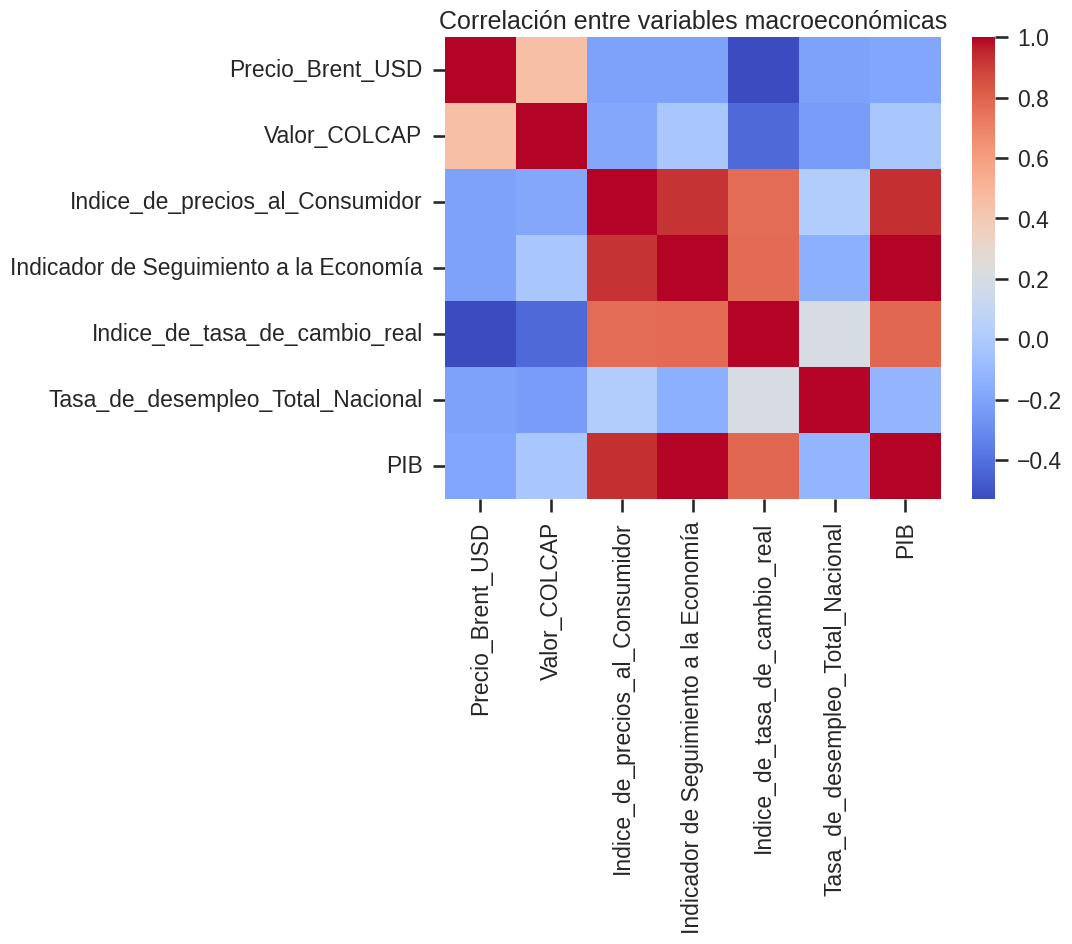

In [33]:
# Tabla de correlaciones
corr = data.corr()
plt.figure(figsize=(8,6)) 
sns.heatmap(corr, cmap="coolwarm")
plt.title("Correlación entre variables macroeconómicas")
plt.show()

## Transformación de los datos [Escalamiento]

En esta sección vamos a proceder con una tranformación de escala en los datos, en este caso una normalización.

La Normalización tiene como intención generar un conjunto de datos que mantenga las relaciones entre variables sin importar la escala de estas, mapeando todos los valores del DataFrame a valores entre [0, 1].

In [ ]:
# Normalizacion
scaler = MinMaxScaler()
data_norm = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

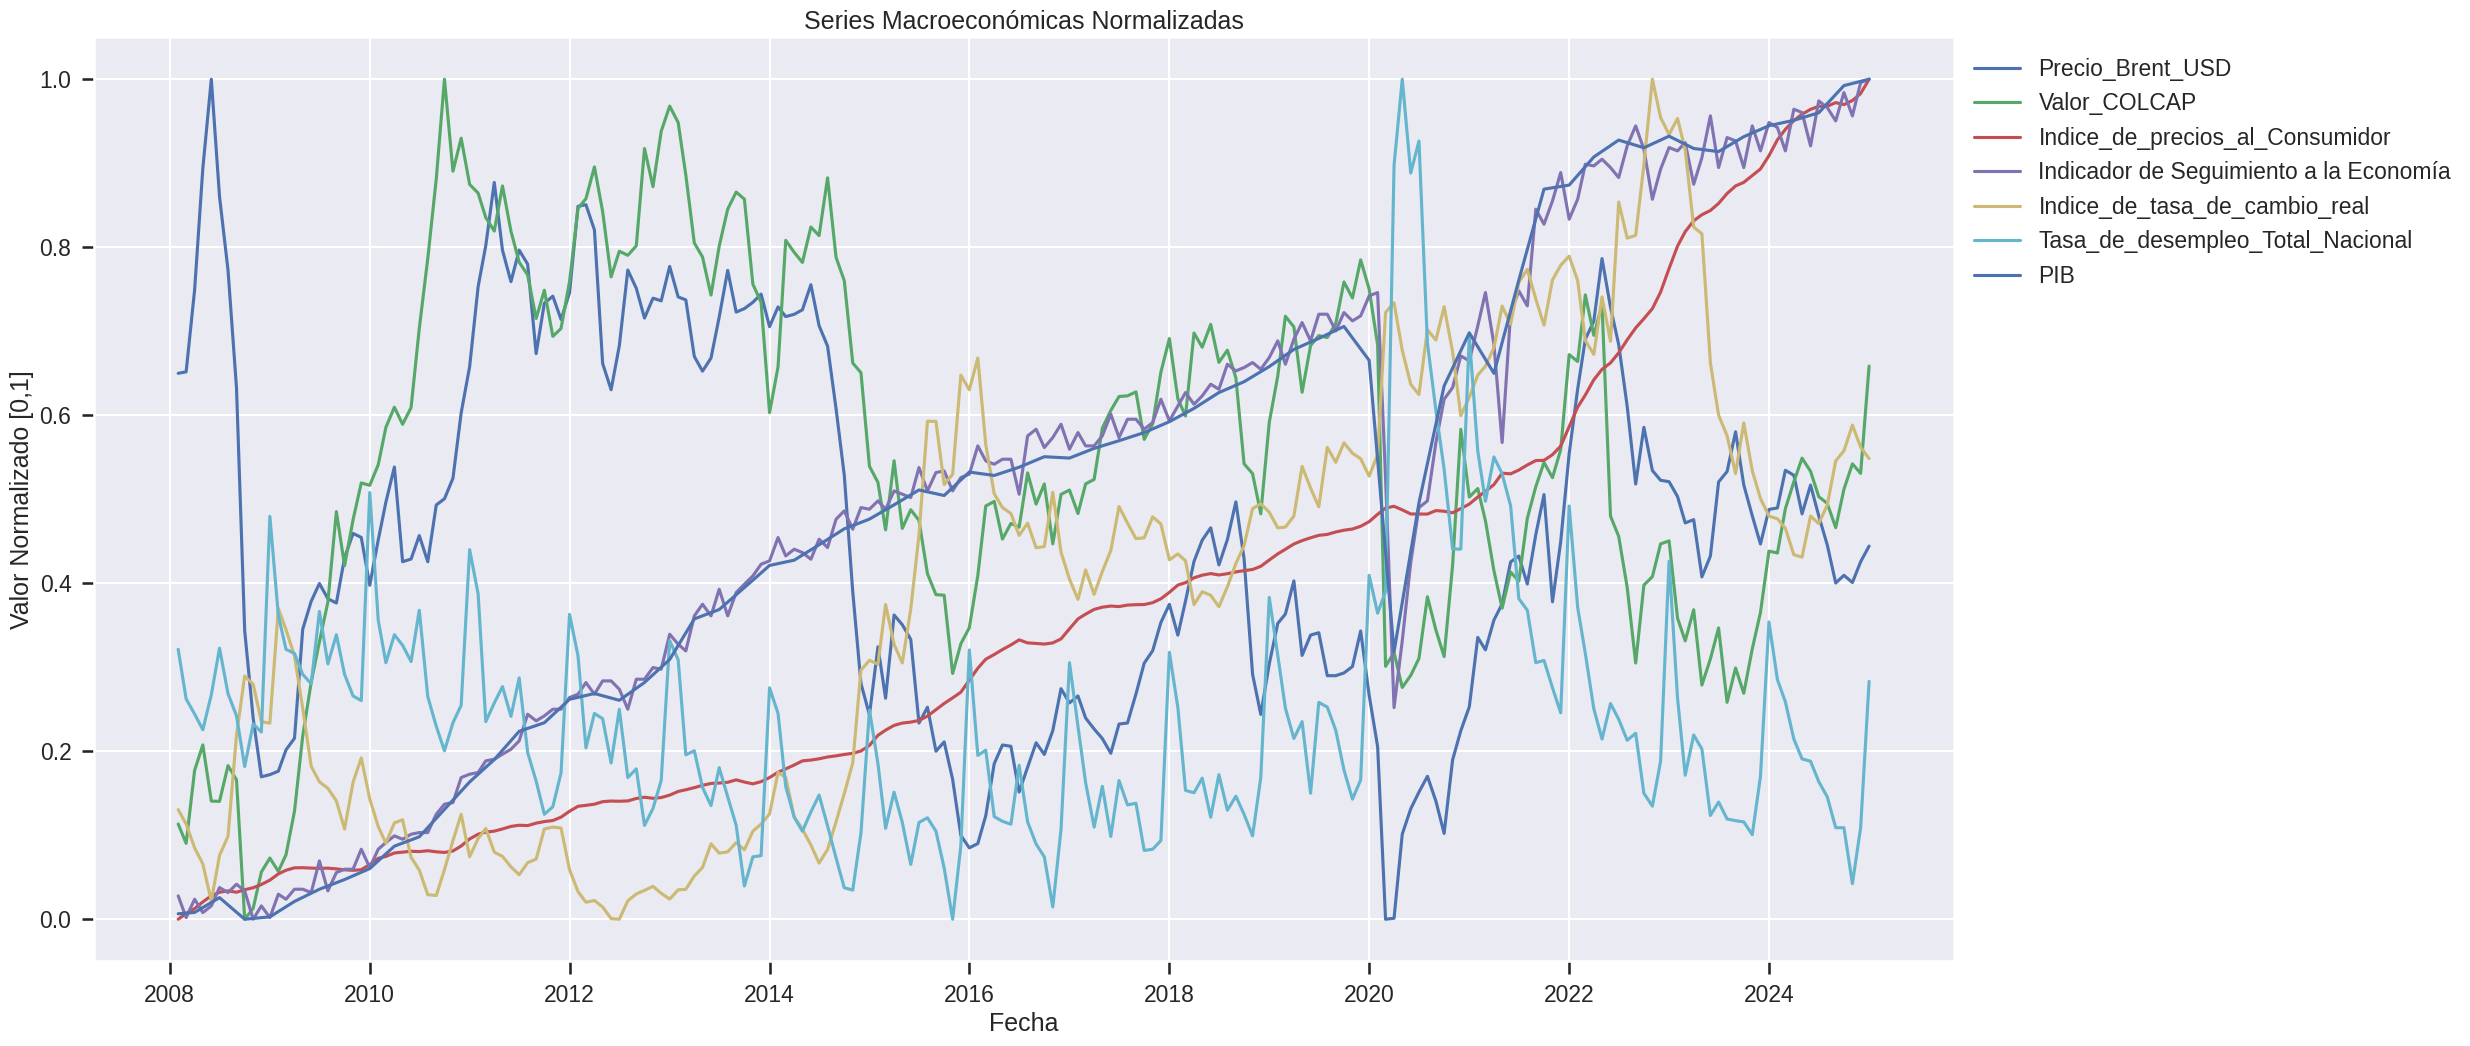

In [59]:
# Gráfica de Datos Normalizados
plt.figure(figsize=(24, 12))

for col in data_norm.columns:
    plt.plot(data_norm.index, data_norm[col], label=col)
plt.title("Series Macroeconómicas Normalizadas")
plt.xlabel("Fecha")
plt.ylabel("Valor Normalizado [0,1]")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

## Time Delay Embedding (Single Embedding)

El Time Delay Embedding es una forma estandar muy utilizada en Análisis Topológico de Datos sobre series de tiempo, en la cual se transforma una serie de tiempo $f(t)$ univariada a una nube de puntos en $\mathbb{R}^{d}$, definiendo una ventana de tiempo de dimensión $d$, un delay $\tau$. Más formalmente, este tipo de transformación se define como una función $TD_{d, \tau}f: \mathbb{R} \to \mathbb{R}^{d}$ donde:

$$
TD_{d,\tau}f(t) =
\begin{pmatrix}
f(t)\\[4pt]
f(t+\tau)\\[4pt]
\vdots\\[4pt]
f\bigl(t+(d-1)\tau\bigr)
\end{pmatrix}
$$

In [ ]:
# Definición de parámetros (single)
embedding_dimension = 3   # Tamaño de la ventana de tiempo (d)
embedding_time_delay = 3  # Delay de evaluación (tau)
stride = 1                # Diferencia entre tiempos de evaluación (t_{i+1} - t_i)

In [ ]:
# Single Time Delay Embedding con GTDA
from gtda.time_series import SingleTakensEmbedding

# Función de Embedding TD_d,tau
embedder_single = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=-1,
    time_delay=embedding_time_delay,
    dimension=embedding_dimension,
    stride=stride,
)

In [125]:
# Transformación de las series de tiempo
single_embeddings = {}

for col in data_norm.columns:
    serie = data_norm[col].values       # debe ser 2D: (n_samples, 1)
    emb = embedder_single.fit_transform(serie)
    single_embeddings[col] = emb

# Convertir a DataFrame o revisar dimensiones
for col in data_norm.columns:
    print(f"{col}: {single_embeddings[col].shape}")

Precio_Brent_USD: (198, 3)
Valor_COLCAP: (198, 3)
Indice_de_precios_al_Consumidor: (198, 3)
Indicador de Seguimiento a la Economía: (198, 3)
Indice_de_tasa_de_cambio_real: (198, 3)
Tasa_de_desempleo_Total_Nacional: (198, 3)
PIB: (198, 3)


In [ ]:
# Código generado por IA, pendiente de Revisión
import plotly.graph_objects as go

variables = df_all["variable"].unique().tolist()
fig = go.Figure()

# Añadir un trace por variable (pero todos ocultos salvo el primero)
for i, var in enumerate(variables):
    df_var = df_all[df_all["variable"] == var]
    visible = True if i == 0 else False
    fig.add_trace(go.Scatter3d(
        x=df_var["x"], y=df_var["y"], z=df_var["z"],
        mode="lines", line=dict(width=3),
        name=var, visible=visible
    ))

# crear botones para el dropdown
buttons = []
for i, var in enumerate(variables):
    visibility = [False] * len(variables)
    visibility[i] = True
    buttons.append(dict(method="update",
                        label=var,
                        args=[{"visible": visibility},
                              {"title": f"Embedding Takens 3D - {var}"}]))

fig.update_layout(
    updatemenus=[dict(active=0, buttons=buttons, x=1.1, y=0.8)],
    scene=dict(xaxis_title="f(t)", yaxis_title="f(t+τ)", zaxis_title="f(t+2τ)"),
    width=800, height=600,
    title=f"Embedding Takens 3D - {variables[0]}"
)

fig.show()


## Time Delay Embedding (MultiTakens Embedding)

La versión MultiTakens de la transformación Time Delay Embedding es una forma se transforma una serie de tiempo $F(t) = \left[f_1(t), ..., f_m(t) \right]$ multivariada a una nube de puntos en $\mathbb{R}^{m \times d}$, definiendo una ventana de tiempo de dimensión $d$, un delay $\tau$. Más formalmente, este tipo de transformación se define como una función $TD_{d, \tau, m}f: \mathbb{R} \to \mathbb{R}^{m \times d}$ donde:

$$
TD_{d,\tau}f(t) =
\begin{pmatrix}
f_1(t)\\[4pt]
f_1(t+\tau)\\[4pt]
\vdots\\[4pt]
f_1\bigl(t+(d-1)\tau\bigr)\\[4pt]
f_2(t)\\[4pt]
\vdots\\[4pt]
f_m(t)\\[4pt]
f_m(t+\tau)\\[4pt]
\vdots\\[4pt]
f_m\bigl(t+(d-1)\tau\bigr)
\end{pmatrix}
$$

En esta transformación se añaden dos parámetros adicionales:
- `flatten` que puede ser `True` si se busca que el resultado quede en un vector que incluya todas las variables indiscriminadamente, o `False` de lo contrario.
- `ensure_last_value` que puede ser `True` si se busca asegurar que se incluya siempre la última observación, sin importar desalineación de los vectores del embedding.

In [ ]:
# Definición de parámetros (Multi)
embedding_dimension = 3   # Tamaño de la ventana de tiempo (d)
embedding_time_delay = 3  # Delay de evaluación (tau)
stride = 1                # Diferencia entre tiempos de evaluación (t_{i+1} - t_i)

In [133]:
# Multivariate Time Delay Embedding con GTDA
from gtda.time_series import TakensEmbedding
 
embedder_multi = TakensEmbedding(
    time_delay=embedding_time_delay,
    dimension=embedding_dimension,
    stride=stride,
    flatten=True,  
    ensure_last_value=True
)

In [ ]:
# Transformación del DataFrame

X = data_norm.values.T              
print(f"shape de los datos originales: {X.shape}")

X_emb = embedder_multi.fit_transform(X)
print(f"Shape del Embedding: {X_emb.shape}")

shape de los datos originales: (7, 204)
Shape del resultado: (7, 198, 3)


In [148]:
# Código generado por IA, pendiente de Revisar
import plotly.graph_objects as go

fig = go.Figure()

for i, col in enumerate(data_norm.columns):
    emb = X_emb[i]
    fig.add_trace(go.Scatter3d(
        x=emb[:, 0],
        y=emb[:, 1],
        z=emb[:, 2],
        mode='lines',
        name=col
    ))

fig.update_layout(
    title='Embeddings Takens por variable macroeconómica',
    scene=dict(
        xaxis_title='f(t)',
        yaxis_title='f(t + τ)',
        zaxis_title='f(t + 2τ)'
    ),
    template='plotly_dark'
)
fig.show()


## Complejo de Vietori-Rips y Persistencia

Como funciona el tema de los complejos Vietori-Rips y la persistencia en Giotto...

https://giotto-ai.github.io/gtda-docs/latest/notebooks/vietoris_rips_quickstart.html

In [ ]:
# Construcción de la filtración sobre el Complejo
from gtda.homology import VietorisRipsPersistence

# 0: componentes, 1: ciclos, 2: cavidades
homology_dimensions = [0, 1, 2]  

VR = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions,
    n_jobs=-1 
)

TypeError: string indices must be integers, not 'tuple'

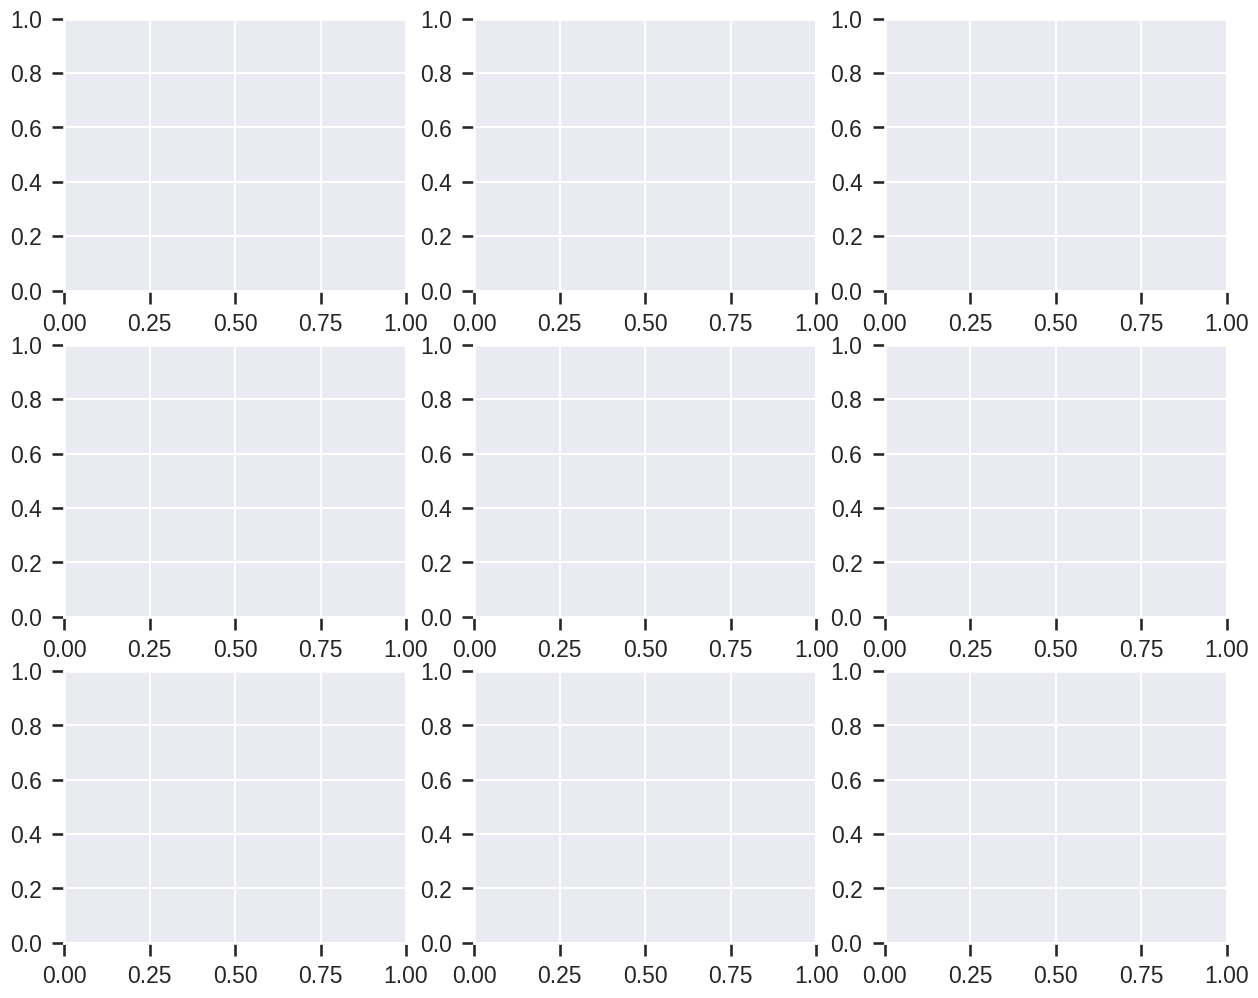

In [ ]:
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram
import matplotlib.pyplot as plt

# Instanciamos el Vietoris-Rips
VR = VietorisRipsPersistence(
    homology_dimensions=[0,1,2],
    n_jobs=-1
)

n_series = len(single_embeddings)
n_cols = 3
n_rows = (n_series + n_cols - 1) // n_cols  # ceil division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))

i = 0
for k in single_embeddings:
    emb = single_embeddings[k]
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    
    # Calcular diagrama de persistencia
    diagrams = VR.fit_transform(emb[None, :, :])  # emb.shape = (n_points, dim), añadimos sample axis
    plot_diagram(diagrams[0], ax=ax, plotly=False)  # matplotlib en subplots
    
    ax.set_title(f"Serie {i+1}")
    i += 1

# Ocultar ejes sobrantes si hay
for j in range(i+1, n_rows*n_cols):
    row = j // n_cols
    col = j % n_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Diagrama de Persistencia Multivariado
X_persistence = VR.fit_transform_plot(X_emb)

/home/daniel/venvs/py312-tda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/daniel/venvs/py312-tda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

